# Classify pictures from auction lots

The auction lots are accompanied with pictures. This notebook performs classification analyses.

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import re

import seaborn as sns
from PIL import Image

from os.path import isfile


In [2]:
# set figure defaults (needs to be in cell seperate from import sns)
matplotlib.rcParams['font.sans-serif'] = ['Helvetica','Arial', 'sans-serif']
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['figure.titlesize'] = 24
matplotlib.rcParams['font.size'] = 18

In [3]:
# file name pattern for images
image_file = lambda lot,idx: '../data/images/{:s}-{:02.0f}.jpg'.format(lot,idx)

# lot number to date
def idx2date(idx):
    M = re.match('([0-9]{4}-[0-9]{1,2})-[0-9]{4}', idx)
    return pd.to_datetime(M[1], format='%Y-%m')

# Load data

In [4]:
fn = '../data/cars-for-imageclf.pkl'
print(fn)
df = pd.read_pickle(fn)
print(df.shape)

# add date
df.loc[:,'auction_date'] = df.reset_index()['index'].apply(idx2date).values

# drop obs with no images stored
df.drop(index=df.index[df.auction_date < pd.to_datetime('2019-02-01')], inplace=True)


# file location to front view pictures
image_file(df.index[-1],0)
df.loc[:,'front_image'] = df.reset_index().loc[:,'index'].apply(lambda l:image_file(l,0)).values

# print result
print(df.shape)
df.tail()


../data/cars-for-imageclf.pkl
(4044, 16)
(987, 18)


,image_urls,brand,model,model_specification,color,age,body_type,convertible,number_of_doors,length,height,width,wheelbase,foreign_registration,registration_number,taxi,auction_date,front_image
2019-8-8161,[http://www.domeinenrz.nl/ufc/static/156458110...,SEAT,ibiza st,,ROOD,2428.0,stationwagen,False,4,4236.0,1445.0,1693.0,2469.0,,43-ZGR-7,False,2019-08-01,../data/images/2019-8-8161-00.jpg
2019-8-8162,[http://www.domeinenrz.nl/ufc/static/156458111...,AUDI,a4,,,6435.0,,False,-1,NaN,NaN,NaN,NaN,Duits,,,2019-08-01,../data/images/2019-8-8162-00.jpg
2019-8-8163,[http://www.domeinenrz.nl/ufc/static/156458111...,FORD,fiesta,,GRIJS,2631.0,hatchback,False,4,3958.0,1481.0,1722.0,2489.0,,66-XBX-1,False,2019-08-01,../data/images/2019-8-8163-00.jpg
2019-8-8168,[http://www.domeinenrz.nl/ufc/static/156458110...,VOLKSWAGEN,polo,,ZWART,3578.0,hatchback,False,4,4064.0,1500.0,1682.0,2456.0,,35-KDF-3,False,2019-08-01,../data/images/2019-8-8168-00.jpg
2019-8-8172,[http://www.domeinenrz.nl/ufc/static/156458110...,BMW,3er reihe,320d sedan aut.,ZWART,5255.0,sedan,False,-1,4520.0,NaN,NaN,2760.0,,16-RG-DD,False,2019-08-01,../data/images/2019-8-8172-00.jpg


## Create openML-like dataset structure

In [5]:
details = {f: t for f,t in zip(
    ['id', 'name', 'version', 'format', 'creator', 'collection_date', 'upload_date', 'licence', 'url', 'file_id', 'default_target_attribute', 'version_label', 'tag', 'visibility', 'original_data_url', 'paper_url', 'status', 'processing_date', 'md5_checksum'],
    [str(), str(), str(), str(), str(), str(), str(), str(), str(), str(), str(), str(), [str()], str(), str(), str(), str(),  str(),str()]
)}

drz = {f: t for f,t in zip(
    ['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'],
    [pd.np.array([]), pd.np.array([]), list(), str(), details, dict(), str()]
)}

In [6]:
# Choose a categorical feature
feature_to_classify = 'brand'
# feature_to_classify = 'body_type'

# meta data
drz['details'].update(dict(
    id='[no id]', 
    name='Dienst Roerende Zaken - {}'.format(feature_to_classify), 
    creator='TvG', 
    original_data_url='https://github.com/r5atom/Saturday-Datascience'))

# target: body type
drz['target'] = df[feature_to_classify].values

### Store pixels values in data set

In [7]:
verbose = 0

#image_size = (1024, 683)
image_size = (128, 85) # aspect 1.5
n_feat = image_size[0] * image_size[1]
n_obs = df.shape[0]
aspect_ratio = image_size[0] / image_size[1]
# empty data array
drz['data'] = pd.np.empty((n_obs, image_size[0] * image_size[1]), int)

# load data into data field
for i,idx in enumerate(df.index):
    if verbose>0: print(i, idx, end=': ')

    fn = df.loc[idx,'front_image']
    # load pixel data
    im = Image.open(fn)
    ar_mismatch = pd.np.log10(im.size[0]/im.size[1] / aspect_ratio)
    if verbose>0: print(im.filename, im.mode, im.size, im.format, '{:+.4f}'.format(ar_mismatch), end= ' > ')
    
    # check dimensions of original and crop if needed
    OK = ((ar_mismatch>0) & (ar_mismatch<0.002)) | ((ar_mismatch<0) & (ar_mismatch>-0.005))
    if not OK:
        if ar_mismatch < 0:
            # second dimension too large: crop from top
            crop_extend = im.size[1] - (im.size[0]/aspect_ratio)
            box = [0, crop_extend, im.size[0], im.size[1]]
            im = im.crop(box=box)
        else: 
            # first dimension too small: crop from left
            crop_extend = im.size[0]-(im.size[1]*aspect_ratio)
            # box = [0, 0, im.size[0]-crop_extend, im.size[1]]
            box = [crop_extend, 0, im.size[0], im.size[1]]
            im = im.crop(box=box)
        if verbose>1: print('\n\t\t\t\t\t\t\t> crop original < {:+.4f}'.format(pd.np.log10(im.size[0]/im.size[1] / aspect_ratio)), end=' ')

    # reduce size and make gray scale
    #im = im.draft('L',(image_size[0]-1,image_size[1]-1))
    im = im.convert('L')
    im = im.resize(image_size)
    if verbose>0: print(im.mode, im.size, im.format)

    # add to data
    drz['data'][i] = im.getdata()

In [8]:
# add feature names
max_digits = list(pd.np.ceil(pd.np.log10(image_size)).astype(int))
pat='front-{{:0{:.0f}.0f}}-{{:0{:.0f}.0f}}'.format(*max_digits)
drz['feature_names'] = [pat.format(i,j) for j in range(0,image_size[1]) for i in range(0,image_size[0])]

### Show an observation

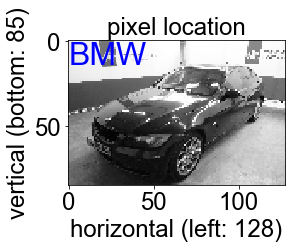

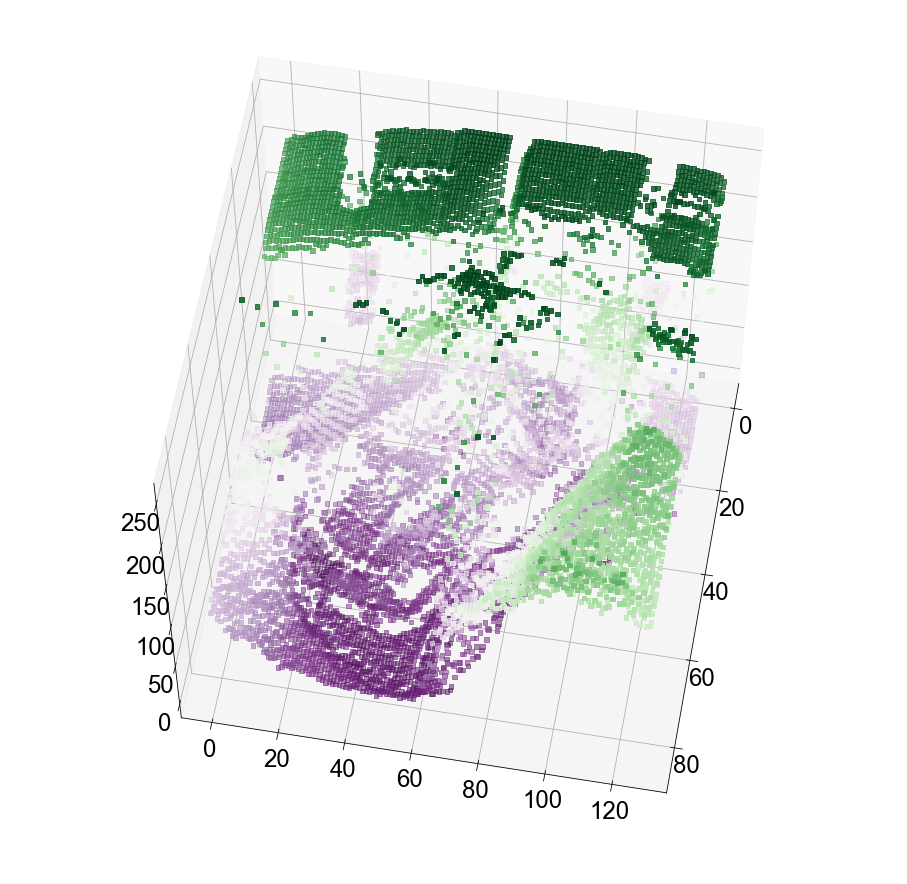

In [9]:
i = -1
obs = drz['data'][i]
obs_image = obs.reshape(image_size[1],image_size[0])
plt.figure(figsize=[d/32 for d in image_size])
plt.imshow(obs_image, cmap='Greys_r')
plt.title('pixel location')
plt.xlabel('horizontal (left: {})'.format(image_size[0]))
plt.ylabel('vertical (bottom: {})'.format(image_size[1]))
plt.text(0, 0, drz['target'][i], ha='left', va='top', fontsize=32, color='b')

# 3d plot
Ms = [re.match('front-([0-9]{{{:g}}})-([0-9]{{{:g}}})'.format(*max_digits),n) for n in drz['feature_names']]
loci = [int(M[1]) for M in Ms]
locj = [int(M[2]) for M in Ms]

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=[16,16])
ax = fig.gca(projection='3d')
ax.view_init(60, 10)
ax.scatter3D(locj, loci, drz['data'][i], marker='s', c=drz['data'][i], cmap='PRGn')


# Predicting classes

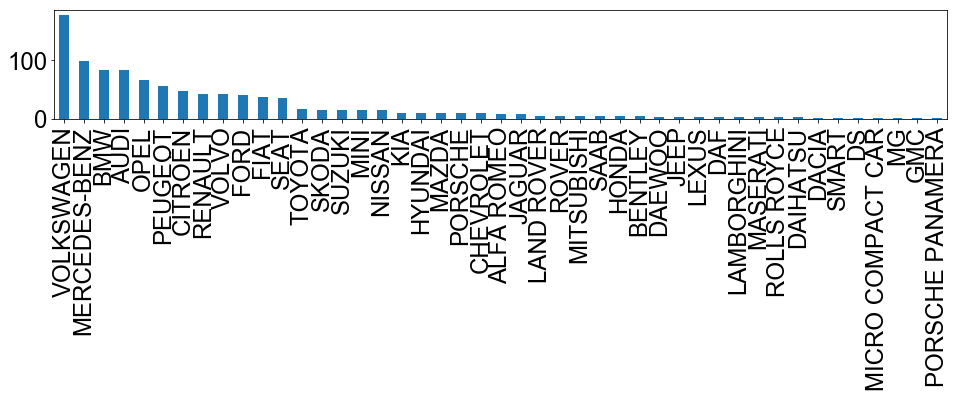

In [10]:
# histogram of occurence (prevalence) of classes
pd.Series(drz['target']).value_counts().plot(kind='bar', figsize=[16,2])

In [11]:
# function to plot exemplars

def plot_observations(observations, image_size=(128,85)):
    '''
    Displays images in one large figure.
    
    Note that the observations are one vector per observation as it is fed to the classifier with every pixel a feature.
    '''
    
    # number of tiles
    n_tiles = len(observations)
    # dimension of output row/columns
    nc = pd.np.floor(pd.np.sqrt(n_tiles)).astype(int) # largest in tile -> floor
    nr = pd.np.ceil(n_tiles/nc).astype(int)
    # adjust 
    n_tiles_rect = nr*nc
    # empty figure
    im_rect = pd.np.ones([image_size[1]*nr, image_size[0]*nc])*256

    # fill rectangle
    for ir in range(nr):
        for ic in range(nc):
            i = ir*nc + ic # tile index
            if i >= n_tiles:
                break
                
            # coordinates in rectangle
            offsetij = (ir*image_size[1], ic*image_size[0])
            coor_i = [b + offsetij[0] for b in [0, image_size[1]]]
            coor_j = [b + offsetij[1] for b in [0, image_size[0]]]
            # put image
            im_rect[
                coor_i[0]:coor_i[1],
                coor_j[0]:coor_j[1]
            ] = observations[i].reshape(image_size[1], image_size[0])

    # prettify
    dpi = 96
    fig = plt.figure(figsize=[nc*image_size[0]/dpi, nr*image_size[1]/dpi], dpi=dpi)
    ax = fig.gca()
    ax.axis('off')
    # place
    ax.imshow(im_rect, cmap='Greys_r')
    

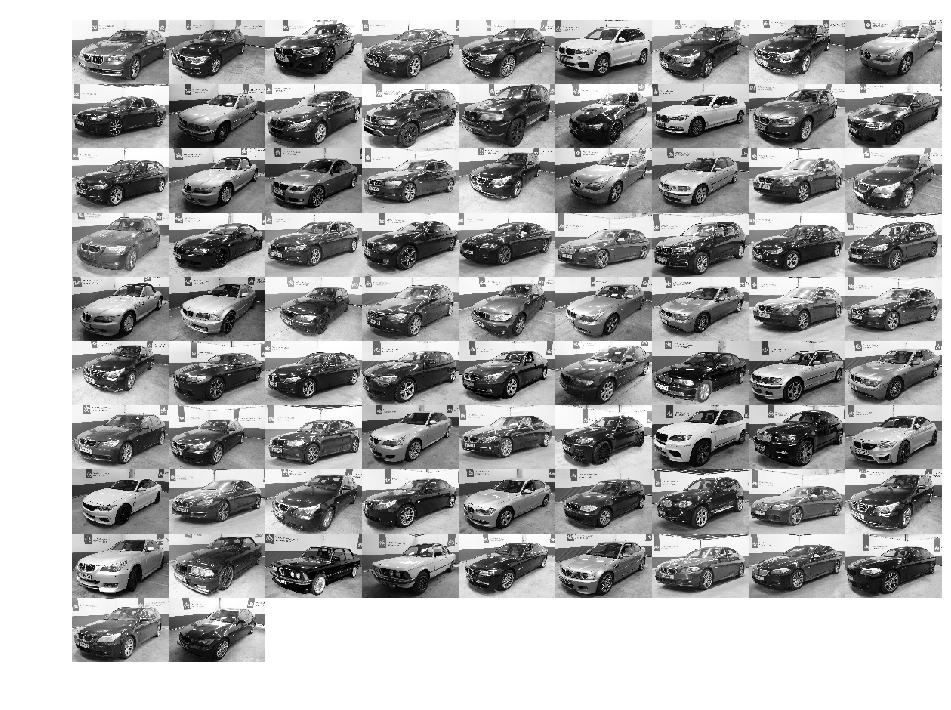

In [12]:
# Plot observations 
sel = drz['target'] == 'BMW'
# sel = drz['target'] == 'sedan'
plot_observations(drz['data'][sel], image_size=image_size)

In [13]:
# empty dict to store models
models = dict()

# Model: Simple binary classifier

## Prepare input

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict

model_name = 'binary classifier with gradient descent'

X, y = drz['data'], drz['target']
print(X.shape)
print(y.shape)

(987, 10880)
(987,)


## Fit

In [15]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

#test_size = 0.3
#i_split = round(n_obs * (1-0.3)) # index where to split
#shuffle_index = pd.np.random.RandomState(seed=42).permutation(n_obs)
#assert shuffle_index[0] == 309 # sanity check
# actual split
#X_train, y_train = X[:i_split], y[:i_split]
#X_test, y_test = X[i_split:], y[i_split:]

# split train/test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

n_test = len(X_test)


(690, 10880)
(297, 10880)


## Binary classifier

Stochastic gradient descent

In [16]:
# class
predict_class = 'AUDI'
y_binary, y_train_binary, y_test_binary = (y == predict_class), (y_train == predict_class), (y_test == predict_class)
# plt.hist(y_train_binary_astype('int'), bins=[-0.5,0.5,1.5])
# plt.hist(y_test_binary.astype('int'), bins=[-0.5,0.5,1.5])

In [17]:
# create classifier
clf = SGDClassifier(random_state=42, verbose=0, fit_intercept=False)
models[model_name].update({'model':clf})

# fit
clf.fit(X_train, y_train_binary)
y_pred = clf.predict(X_test)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})
models[model_name].update({'classes':[predict_class]})

# parameters
betas = [clf.intercept_[0], *clf.coef_[0]] # index 0 because of two classes
models[model_name].update({'betas':betas})

# scoring

# accuracy
models[model_name].update({'acc':clf.score(X,y_binary)})
models[model_name].update({'test acc':clf.score(X_test,y_test_binary)})
cv_results = cross_val_score(clf, X_test, y_test_binary, cv=5, scoring='accuracy')
models[model_name].update({'cv acc':cv_results})
# f1
models[model_name].update({'f1':f1_score(y_binary, clf.predict(X))})
models[model_name].update({'test f1':f1_score(y_test_binary, y_pred)})
cv_results = cross_val_score(clf, X_test, y_test_binary, cv=5, scoring='f1')
models[model_name].update({'cv f1':cv_results})

# sanity check to see if score is accuracy
y_train_pred = clf.predict(X_train)
assert sum(y_pred == y_test_binary) / n_test == clf.score(X_test,y_test_binary)
assert sum(y_pred == y_test_binary) / n_test == models[model_name]['test acc']

/Users/Tom/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Tom/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


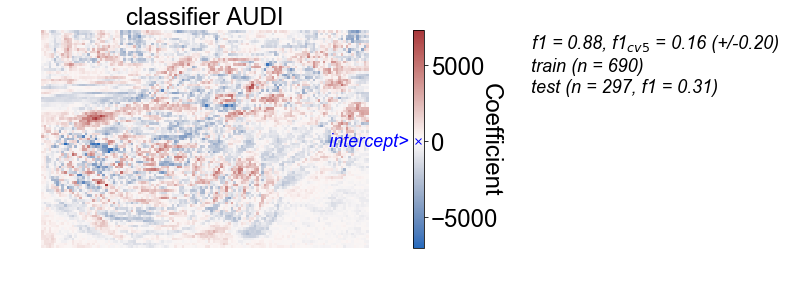

In [18]:
# plot classifier
plt.figure(figsize=[16,4])
plt.imshow(pd.np.array(betas[1:]).reshape([image_size[1], image_size[0]]), cmap='vlag')
plt.axis('off')
plt.title('classifier {}'.format(predict_class))
cbar = plt.colorbar()
cbar.set_label('Coefficient', rotation=270)
cbar.ax.plot(0, models[model_name]['betas'][0], 'xb')
cbar.ax.text(0, models[model_name]['betas'][0], '  intercept>  ', style='italic', color='b', va='center', ha='right')
# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.5,xy[1], 'f1 = {:.2f}, f1$_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['f1'],
    models[model_name]['cv f1'].shape[0],
    pd.np.mean(models[model_name]['cv f1']),
    pd.np.std(models[model_name]['cv f1']),
) + '\n' +
         'train (n = {})'.format(y_train_binary.shape[0]) + '\n' +
         'test (n = {}, f1 = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test f1'],
         ), style='italic', va='top', ha='left')


# Save
plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

In [19]:
# Cross validation
# cross_validate(clf, X_test, y_test_binary, cv=8, scoring=['accuracy', 'balanced_accuracy', 'f1'], verbose=3, n_jobs=4)

# Model: random forest

## Prepare input

In [20]:
from sklearn.ensemble import RandomForestClassifier

model_name = 'random forest'

X, y = drz['data'], drz['target']
print(X.shape)
print(y.shape)

(987, 10880)
(987,)


## Fit

In [21]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

#test_size = 0.3
#i_split = round(n_obs * (1-0.3)) # index where to split
#shuffle_index = pd.np.random.RandomState(seed=42).permutation(n_obs)
#assert shuffle_index[0] == 309 # sanity check
# actual split
#X_train, y_train = X[:i_split], y[:i_split]
#X_test, y_test = X[i_split:], y[i_split:]

# split train/test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

n_test = len(X_test)


(690, 10880)
(297, 10880)


## Binary classifier

Random Forest Classifier

In [22]:
# class
predict_class = 'AUDI'
y_binary, y_train_binary, y_test_binary = (y == predict_class), (y_train == predict_class), (y_test == predict_class)
# plt.hist(y_train_binary_astype('int'), bins=[-0.5,0.5,1.5])
# plt.hist(y_test_binary.astype('int'), bins=[-0.5,0.5,1.5])

In [23]:
# create classifier
clf = RandomForestClassifier(random_state=42, verbose=1)
models[model_name].update({'model':clf})

# fit
clf.fit(X_train, y_train_binary)
y_pred = clf.predict(X_test)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})
models[model_name].update({'classes':[predict_class]})

# parameters
betas = [pd.np.NaN, clf.feature_importances_] # NaN, because rndforclf has no intercept
models[model_name].update({'betas':betas})

# scoring

# accuracy
models[model_name].update({'acc':clf.score(X,y_binary)})
models[model_name].update({'test acc':clf.score(X_test,y_test_binary)})
cv_results = cross_val_score(clf, X_test, y_test_binary, cv=5, scoring='accuracy')
models[model_name].update({'cv acc':cv_results})
# f1
models[model_name].update({'f1':f1_score(y_binary, clf.predict(X))})
models[model_name].update({'test f1':f1_score(y_test_binary, y_pred)})
cv_results = cross_val_score(clf, X_test, y_test_binary, cv=5, scoring='f1')
models[model_name].update({'cv f1':cv_results})

# sanity check to see if score is accuracy
y_train_pred = clf.predict(X_train)
assert sum(y_pred == y_test_binary) / n_test == clf.score(X_test,y_test_binary)
assert sum(y_pred == y_test_binary) / n_test == models[model_name]['test acc']
assert clf.n_features_ == X.shape[1]


/Users/Tom/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finishe

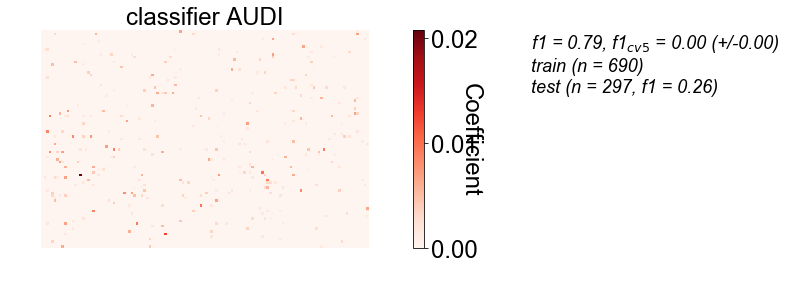

In [24]:
# plot classifier
plt.figure(figsize=[16,4])
plt.imshow(pd.np.array(betas[1:]).reshape([image_size[1], image_size[0]]), cmap='Reds')
plt.axis('off')
plt.title('classifier {}'.format(predict_class))
cbar = plt.colorbar()
cbar.set_label('Coefficient', rotation=270)
# cbar.ax.plot(0, models[model_name]['betas'][0], 'xb')
# cbar.ax.text(0, models[model_name]['betas'][0], '  intercept>  ', style='italic', color='b', va='center', ha='right')
# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.5,xy[1], 'f1 = {:.2f}, f1$_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['f1'],
    models[model_name]['cv f1'].shape[0],
    pd.np.mean(models[model_name]['cv f1']),
    pd.np.std(models[model_name]['cv f1']),
) + '\n' +
         'train (n = {})'.format(y_train_binary.shape[0]) + '\n' +
         'test (n = {}, f1 = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test f1'],
         ), style='italic', va='top', ha='left')


# Save
plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

# Model performances

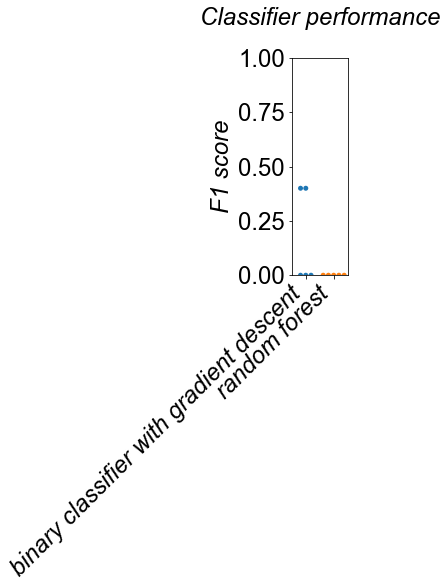

In [25]:
# plot f1
k = 'cv f1'

# counter for x-offset
c=0

# figure
fig = plt.figure(figsize=[1,4])
ax = fig.gca()
xs = ys = [None]

# loop over all models
for name,res in models.items():

    c+=1 # x-offset

    score = res[k]
    
    # add scores and offset to vectors
    ys = pd.np.concatenate([ys,score])
    xs = pd.np.concatenate([xs,pd.np.ones_like(score) * c])

# actual plotting
sns.swarmplot(x=xs, y=ys, ax=ax)
# prettify
ax.set_xticklabels(models.keys(), rotation=45, va='top', ha='right', style='italic')
ax.set_ylim(bottom=0, top=1)
ax.set_title('Classifier performance\n', style='italic')
ax.set_ylabel('F1 score', style='italic')

# save
plt.savefig('../results/model-performance-classification.png', bbox_inches='tight', transparent=True)

### Confusion matrix
https://en.wikipedia.org/wiki/Precision_and_recall

In [26]:
# plot confusion matrix
def plot_confusion_matrix(mtx, class_name):
    '''
    Present the confusion matrix as an image
    '''
    
    # results
    n_tp = mtx[1,1] # hit
    n_tn = mtx[0,0] # corr reject
    n_fp = mtx[0,1] # false alarm, Type I err
    n_fn = mtx[1,0] # miss, Type II err
    n_cp = sum(mtx[1,:]) # condition pos
    n_cn = sum(mtx[0,:]) # condition neg
    n_pp = sum(mtx[:,1]) # prediction pos
    n_pn = sum(mtx[:,0]) # prediction negative
    n_corr = n_tp + n_tn
    n_wrong = n_fp + n_fn

    plt.figure(figsize=[4,4])
    # rotate axis to get true pos upper left
    plt.xlim(left=1.5, right=-0.5)
    plt.ylim(top=1.5, bottom=-0.5)
    # prettify
    plt.xlabel('Predicted', style='italic')
    plt.ylabel('Real', style='italic')
    plt.title('Confusion matrix\n(n={})'.format(sum(mtx.ravel())), style='italic')
    plt.xticks(ticks=[0,1], labels=['not a ' + class_name, class_name])
    plt.yticks(ticks=[0,1], labels=['not a ' + class_name, class_name])

    # plot image
    im = plt.imshow(mtx, cmap='Blues_r')
    
    # add values
    for ir, pred in enumerate(mtx):
        for ic, n in enumerate(pred):
            plt.text(ic, ir, str(n), va='center', ha='center', weight='bold')

    # add summed values
    plt.text(-0.5, -0.5, n_corr, va='top', ha='left', style='italic')
    plt.text(-0.5, 1.5, n_wrong, va='bottom', ha='left', style='italic')
    plt.text(0, -0.5, n_pn, va='bottom', ha='center', style='italic')
    plt.text(1, -0.5, n_pp, va='bottom', ha='center', style='italic')
    plt.text(-0.5, 0, n_cn, va='center', ha='right', style='italic')
    plt.text(-0.5, 1, n_cp, va='center', ha='right', style='italic')

    # other stats
    recall = n_tp/n_cp # true pos rate
    specificity = n_tn/n_cn # true neg rate
    F1 = 2*(recall * specificity / (recall + specificity))
    accu = n_corr / (n_corr + n_wrong)
    bacc = (recall + specificity)/2
    prec = n_tp/n_pp

    
    xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
    plt.text(xy[0]*1.2,xy[1],'\n'.join([
        'F1: {:.3f}', 
        'accuracy:{:.1%}',
        'balanced acc.: {:.1%}',
        'precision: {:.1%}',
        'recall: {:.1%}',
        'specificity: {:.1%}'
    ]).format(F1, accu, bacc, prec, recall, specificity),
             va='top', ha='left', style='italic'
            )

[[275   4]
 [ 14   4]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[[277   2]
 [ 15   3]]


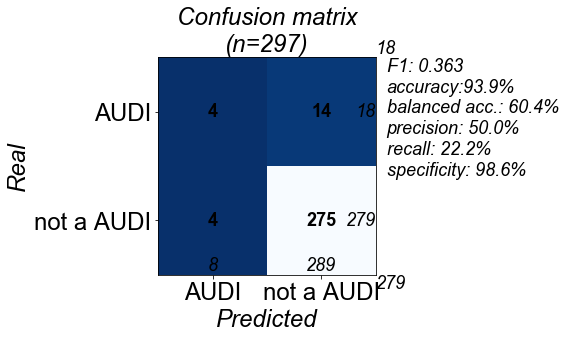

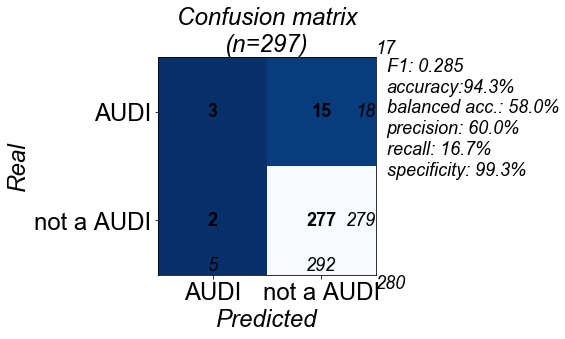

In [27]:
for model_name, model in models.items():
    clf = model['model']
    predict_class = model['classes'][0]
    y_pred = clf.predict(X_test)
    y_test_binary = y_test == predict_class

    
    conf_mtx = confusion_matrix(y_test_binary, y_pred)
    print(conf_mtx)
    # True negatives:  [0,0]
    # False negatives: [1,0]
    # True positives:  [1,1] 
    # False positives: [0,1].
    assert sum(conf_mtx[:,1]) == sum(y_pred)
    assert sum(conf_mtx[1,:]) == sum(y_test_binary)
    assert conf_mtx[0,0] == sum(~y_pred & ~y_test_binary) # correct negative

    plot_confusion_matrix(conf_mtx, predict_class)

    # save
    plt.savefig('../results/confusion-matrix-{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


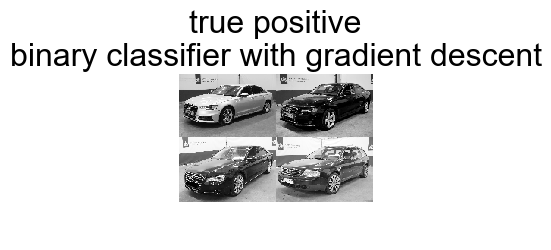

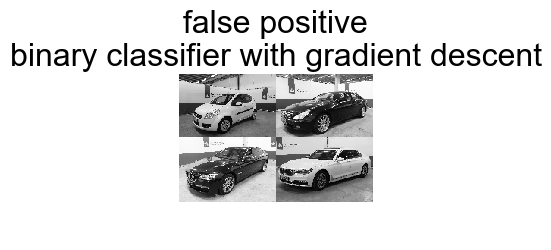

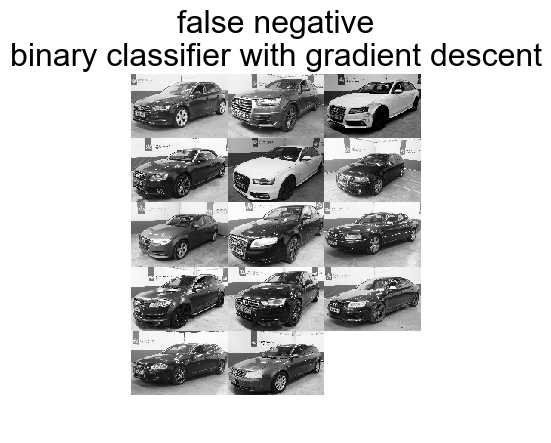

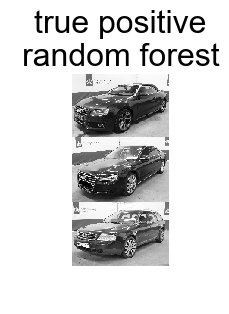

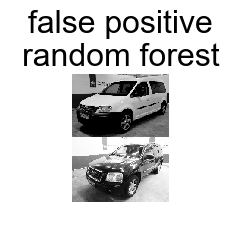

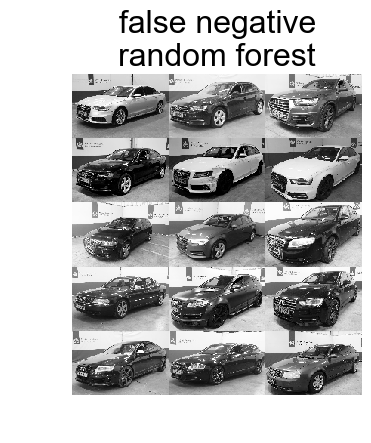

In [28]:
# plot classification errors
for model_name, model in models.items():
    clf = model['model']
    y_pred = clf.predict(X_test)
    y_test_binary = y_test == model['classes'][0]

    tp_test = y_pred & y_test_binary
    fp_test = y_pred & ~y_test_binary
    fn_test = ~y_pred & y_test_binary

    plot_observations(X_test[tp_test], image_size=image_size)
    plt.title('true positive\n' + model_name)

    plot_observations(X_test[fp_test], image_size=image_size)
    plt.title('false positive\n' + model_name)

    plot_observations(X_test[fn_test], image_size=image_size)
    plt.title('false negative\n' + model_name)


### ROC curve

In [29]:
# plot ROC curve
def plot_roc_curve(fpr, fnr, auc):
    '''
    Plot ROC curve. False positive (fpr) and False negative(fnr) rates are already calculated, so is area under the ROC curve (auc).
    '''
    
    
    plt.figure(figsize=[8,8])
    plt.plot([0,1], [0,1], '--k')
    plt.plot(fpr, fnr, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(ticks=pd.np.linspace(0,1,3))
    plt.yticks(ticks=pd.np.linspace(0,1,3))
    plt.xlabel('False positive rate', style='italic')
    plt.ylabel('True positive rate', style='italic')
    plt.title('ROC curve', style='italic')


    # stats
    xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
    plt.text(xy[0]*1.05,xy[1],'\n'.join([
        'AUC test set: {:.3f}', 
    ]).format(auc),
             va='top', ha='left', style='italic'
            )



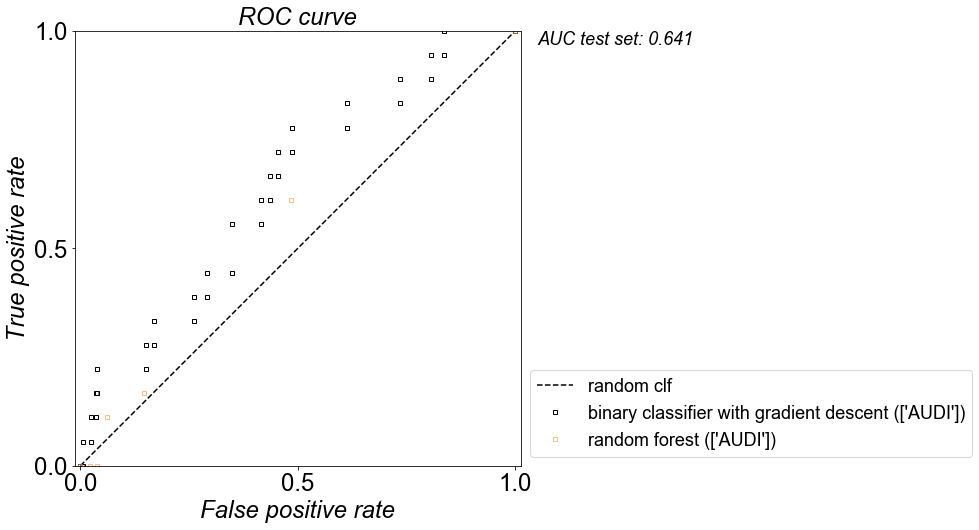

In [30]:
# plot ROC

# assemble results
fprs, fnrs, aucs = [[],[],[]]
for model_name, model in models.items():
    clf = model['model']

    # Scores at all thresholds. 'cross_val_score' uses theshold 0
    if model_name == 'binary classifier with gradient descent':
        clf_scores = cross_val_predict(clf, X_test, y_test_binary, cv=8, method="decision_function", n_jobs=4)
    else:
        clf_scores = cross_val_predict(clf, X_test, y_test_binary, cv=8, method="predict_proba", n_jobs=4)[:,1]
    fpr, fnr, thresholds = roc_curve(y_test_binary, clf_scores)
    auc = roc_auc_score(y_test_binary, clf_scores)
    fprs += [fpr]
    fnrs += [fnr]
    aucs += [auc]

# first creates a plot
plot_roc_curve(fprs[0], fnrs[0], aucs[0])
# add to plot
for fpr, fnr, auc in zip(fprs[1:], fnrs[1:], aucs[1:]):
    plt.plot(fprs[1], fnrs[1], marker='s', markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4)
# legend
labels = ['{} ({})'.format(m, models[m]['classes']) for m in models]
plt.legend(['random clf'] + labels, loc='lower left', bbox_to_anchor=[1, 0])


# save
plt.savefig('../results/ROC-curves.png', bbox_inches='tight', transparent=True)

openML has the following structure: 

```
from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784')
iris = fetch_openml('iris')

# choose dataset
openml_dataset = iris
openml_dataset.keys()



dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])
```
- - - 
The dictonary has the following keys

```
for k in openml_dataset:
    print(k, type(openml_dataset[k]))



data <class 'numpy.ndarray'>
target <class 'numpy.ndarray'>
feature_names <class 'list'>
DESCR <class 'str'>
details <class 'dict'>
categories <class 'dict'>
url <class 'str'>
```
- - - 
The fields contain the following
```
# create table
head = ['field', 'type', 'length']
width = [32, 32, 8]
pat = ['{{:>{}s}} | {{:{}s}} | {{:>{}s}}'.format(*width),
       '{{:>{}s}}-+-{{:{}s}}-+-{{:<{}s}}'.format(*width),
       '{{:>{}s}} | {{:{}s}} | {{:{}.0f}}'.format(*width),
      ]
sep = pat[1].format(''.join(['-']*width[0]), ''.join(['-']*width[1]), ''.join(['-']*width[2]))


# header
print(openml_dataset['details']['id'], openml_dataset['details']['name'], openml_dataset['details']['version'], openml_dataset['details']['original_data_url'], )
print(pat[0].format(*head))
print(sep)
# values
for k in openml_dataset:
    print(pat[2].format(k, str(type(openml_dataset[k])), len(openml_dataset[k])))

# deeper dict
k = 'details'
print(sep)
print(pat[0].format('{}[field]'.format(k), 'type', 'length'))
print(sep)
for kk in openml_dataset[k]:
    print(pat[2].format(kk, str(type(openml_dataset[k][kk])), len(openml_dataset[k][kk])))



61 iris 1 https://archive.ics.uci.edu/ml/datasets/Iris
                           field | type                             |   length
---------------------------------+----------------------------------+---------
                            data | <class 'numpy.ndarray'>          |      150
                          target | <class 'numpy.ndarray'>          |      150
                   feature_names | <class 'list'>                   |        4
                           DESCR | <class 'str'>                    |      932
                         details | <class 'dict'>                   |       19
                      categories | <class 'dict'>                   |        0
                             url | <class 'str'>                    |       27
---------------------------------+----------------------------------+---------
                  details[field] | type                             |   length
---------------------------------+----------------------------------+---------
                              id | <class 'str'>                    |        2
                            name | <class 'str'>                    |        4
                         version | <class 'str'>                    |        1
                          format | <class 'str'>                    |        4
                         creator | <class 'str'>                    |       11
                 collection_date | <class 'str'>                    |        4
                     upload_date | <class 'str'>                    |       19
                         licence | <class 'str'>                    |        6
                             url | <class 'str'>                    |       52
                         file_id | <class 'str'>                    |        2
        default_target_attribute | <class 'str'>                    |        5
                   version_label | <class 'str'>                    |        1
                             tag | <class 'list'>                   |       11
                      visibility | <class 'str'>                    |        6
               original_data_url | <class 'str'>                    |       44
                       paper_url | <class 'str'>                    |       63
                          status | <class 'str'>                    |        6
                 processing_date | <class 'str'>                    |       19
                    md5_checksum | <class 'str'>                    |       32
```
- - -
Size of _data_ and _target_ are
```
print(openml_dataset['data'].shape)
print(openml_dataset['target'].shape)



(150, 4)
(150,)
```

In [31]:
raise # throw a error to stop evaluation

RuntimeError: No active exception to reraise

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
iris = fetch_openml('iris')

In [ ]:
openml_dataset = drz
openml_dataset.keys()

In [ ]:
iris['categories']

In [ ]:
# create table
head = ['field', 'type', 'length']
width = [32, 32, 8]
pat = ['{{:>{}s}} | {{:{}s}} | {{:>{}s}}'.format(*width),
       '{{:>{}s}}-+-{{:{}s}}-+-{{:<{}s}}'.format(*width),
       '{{:>{}s}} | {{:{}s}} | {{:{}.0f}}'.format(*width),
      ]
sep = pat[1].format(''.join(['-']*width[0]), ''.join(['-']*width[1]), ''.join(['-']*width[2]))


# header
print(openml_dataset['details']['id'], openml_dataset['details']['name'], openml_dataset['details']['version'], openml_dataset['details']['original_data_url'], )
print(pat[0].format(*head))
print(sep)
# values
for k in openml_dataset:
    print(pat[2].format(k, str(type(openml_dataset[k])), len(openml_dataset[k])))

# deeper dict
k = 'details'
print(sep)
print(pat[0].format('{}[field]'.format(k), 'type', 'length'))
print(sep)
for kk in openml_dataset[k]:
    print(pat[2].format(kk, str(type(openml_dataset[k][kk])), len(openml_dataset[k][kk])))


In [ ]:
print(openml_dataset['data'].shape)
print(openml_dataset['target'].shape)


In [ ]:
openml_dataset['details'].keys()

In [ ]:
mnist['feature_names']